# Boston 311 Tutorial

This notebook will run you through the basic usage of this package to train 4 models on the Boston 311 data and use them to predict the outcome of cases from the last 30 days

In [1]:
#The lifelines library is only needed for the Cox Regression Model, which is not included in this tutorial
#The keras-tuner library is needed for the neural network model
#The seaborn library is needed for visualization of results at the end
! pip install -q lifelines keras-tuner seaborn

In [2]:
#! pip install git+https://github.com/mindfulcoder49/Boston_311.git

! pip install . 

Defaulting to user installation because normal site-packages is not writeable
Processing /home/briarmoss/Documents/Boston_311
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for boston311: filename=boston311-0.2.0-py3-none-any.whl size=24770 sha256=216c198e62d3710749c30872576e74ceeb6df52a9cb9efd7069c62444220e27d
  Stored in directory: /tmp/pip-ephem-wheel-cache-8f1bz_17/wheels/3d/69/ee/0a6ac96b9c09c948fc0e74f2724a9703aa39749a41fa757c9e
Successfully built boston311
  Attempting uninstall: boston311
    Found existing installation: boston311 0.2.0
    Uninstalling boston311-0.2.0:
      Successfully uninstalled boston311-0.2.0


## Import the Boston311Model classes

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras_tuner import HyperParameters

Using TensorFlow backend


/home/briarmoss/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2023-11-30 12:16:12.954717: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-30 12:16:12.996936: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-30 12:16:12.997658: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-30 12:16:13.514541: W tensorfl

In [4]:
from boston311 import Boston311LogReg, Boston311EventDecTree, Boston311SurvDecTree, Boston311KerasNN

## Get latest file URLS, Data, and Current Date Ranges

In [5]:
latest_URLS = Boston311LogReg().get311URLs()

trying to get csv URLs
Found URL: https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/e6013a93-1321-4f2a-bf91-8d8a02f1e62f/download/tmp2ymq3opb.csv for year 2023
Found URL: https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/81a7b022-f8fc-4da5-80e4-b160058ca207/download/tmpfm8veglw.csv for year 2022
Found URL: https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/f53ebccd-bc61-49f9-83db-625f209c95f5/download/tmp88p9g82n.csv for year 2021
Found URL: https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/6ff6a6fd-3141-4440-a880-6f60a37fe789/download/tmpcv_10m2s.csv for year 2020
Found URL: https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/ea2e4696-4a2d-429c-9807-d02eb92e0222/download/tmpcje3ep_w.csv for year 2019
Found URL: https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/2be28d90-3a90-4af1-a3f6-f28c1e25880a/download/tmp7602cia8.csv f

In [6]:
print(latest_URLS)

{'2023': 'https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/e6013a93-1321-4f2a-bf91-8d8a02f1e62f/download/tmp2ymq3opb.csv', '2022': 'https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/81a7b022-f8fc-4da5-80e4-b160058ca207/download/tmpfm8veglw.csv', '2021': 'https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/f53ebccd-bc61-49f9-83db-625f209c95f5/download/tmp88p9g82n.csv', '2020': 'https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/6ff6a6fd-3141-4440-a880-6f60a37fe789/download/tmpcv_10m2s.csv', '2019': 'https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/ea2e4696-4a2d-429c-9807-d02eb92e0222/download/tmpcje3ep_w.csv', '2018': 'https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/2be28d90-3a90-4af1-a3f6-f28c1e25880a/download/tmp7602cia8.csv', '2017': 'https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/300221

In [7]:
today_datestring, tomorrow_datestring, thirty_days_ago_datestring = Boston311LogReg().get_datestrings()

## Define several models

In [8]:
linear_tree_model = Boston311SurvDecTree(train_date_range={'start':'2023-01-01','end':thirty_days_ago_datestring},
                            predict_date_range={'start':thirty_days_ago_datestring,'end':today_datestring},
                            feature_columns=['type','queue'],
                            scenario={'dropColumnValues': {'source':['City Worker App', 'Employee Generated']},
                                      'survivalTimeMin':0,
                                      'survivalTimeFill':tomorrow_datestring},
                            files_dict=latest_URLS)

hour_interval = 48
max_days = 120

linear_tree_model.bin_edges = linear_tree_model.generate_time_bins_fixed_interval(hour_interval, max_days)
linear_tree_model.bin_labels = linear_tree_model.generate_bin_labels(linear_tree_model.bin_edges)

In [9]:
logistic_model = Boston311LogReg(train_date_range={'start':'2023-01-01','end':thirty_days_ago_datestring},
                            predict_date_range={'start':thirty_days_ago_datestring,'end':today_datestring},
                            feature_columns=['type', 'queue'],
                            scenario={'dropColumnValues': {'source':['City Worker App', 'Employee Generated']},
                                      'survivalTimeMin':0},
                            files_dict=latest_URLS)

In [10]:
logistic_tree_model = Boston311EventDecTree(train_date_range={'start':'2023-01-01','end':thirty_days_ago_datestring},
                            predict_date_range={'start':thirty_days_ago_datestring,'end':today_datestring},
                            feature_columns=['type', 'queue'],
                            scenario={'dropColumnValues': {'source':['City Worker App', 'Employee Generated']},
                                      'survivalTimeMin':0},
                            files_dict=latest_URLS)

## Load the data once and store it for use on all the models

In [11]:
all_2023_data = Boston311LogReg(train_date_range={'start':'2023-01-01','end':'2023-12-31'}).load_data()

Checking files_dict
files_dict is None
trying to call get311URLs
trying to get csv URLs
Found URL: https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/e6013a93-1321-4f2a-bf91-8d8a02f1e62f/download/tmp2ymq3opb.csv for year 2023
Found URL: https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/81a7b022-f8fc-4da5-80e4-b160058ca207/download/tmpfm8veglw.csv for year 2022
Found URL: https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/f53ebccd-bc61-49f9-83db-625f209c95f5/download/tmp88p9g82n.csv for year 2021
Found URL: https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/6ff6a6fd-3141-4440-a880-6f60a37fe789/download/tmpcv_10m2s.csv for year 2020
Found URL: https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/ea2e4696-4a2d-429c-9807-d02eb92e0222/download/tmpcje3ep_w.csv for year 2019
Found URL: https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resourc

/home/briarmoss/.local/lib/python3.10/site-packages/boston311/Boston311Model.py:336: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


In [12]:
prediction_data_2023 = linear_tree_model.load_data(data=all_2023_data, train_or_predict='predict')    

In [13]:
case_data_2023 = linear_tree_model.load_data(data=all_2023_data)

## Train several models

In [14]:
logistic_tree_model.run_pipeline(data=case_data_2023)

Starting Training at 2023-11-30 12:17:04.381527
Testing accuracy: 0.9552346112368104
Ending Training at 2023-11-30 12:17:17.207424
Training took 0:00:12.825897


0.9552346112368104

In [15]:
logistic_tree_prediction = logistic_tree_model.predict(data=prediction_data_2023)

columns in data before drop: Index(['case_enquiry_id', 'open_dt', 'sla_target_dt', 'closed_dt', 'on_time',
       'case_status', 'closure_reason', 'case_title', 'subject', 'reason',
       'type', 'queue', 'department', 'submitted_photo', 'closed_photo',
       'location', 'fire_district', 'pwd_district', 'city_council_district',
       'police_district', 'neighborhood', 'neighborhood_services_district',
       'ward', 'precinct', 'location_street_name', 'location_zipcode',
       'latitude', 'longitude', 'geom_4326', 'source', 'survival_time',
       'event', 'ward_number', 'survival_time_hours'],
      dtype='object')
columns to drop: Index(['case_status', 'case_title', 'city_council_district', 'closed_dt',
       'closed_photo', 'closure_reason', 'department', 'fire_district',
       'geom_4326', 'latitude', 'location', 'location_street_name',
       'location_zipcode', 'longitude', 'neighborhood',
       'neighborhood_services_district', 'on_time', 'open_dt',
       'police_distric

/home/briarmoss/.local/lib/python3.10/site-packages/boston311/Boston311Model.py:267: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, fake_df], ignore_index=True)


In [16]:
logistic_tree_prediction['event_prediction'].value_counts()

event_prediction
1    14446
0     5864
Name: count, dtype: int64

In [17]:
logistic_tree_prediction[logistic_tree_prediction['event'] == 0].head(100)

,event_prediction,case_enquiry_id,open_dt,sla_target_dt,closed_dt,on_time,case_status,closure_reason,case_title,subject,...,location_street_name,location_zipcode,latitude,longitude,geom_4326,source,survival_time,event,ward_number,survival_time_hours
268077,0,101005148035,2023-10-31 03:04:54,2023-11-01 04:30:00,NaT,OVERDUE,Open,,Parking Enforcement,Transportation - Traffic Division,...,52 Sullivan St,2129.0,42.378850,-71.065470,0101000020E61000005020D5AA30C451C015FC2C247E30...,Citizens Connect App,NaT,0,2,NaN
268080,0,101005148042,2023-10-31 03:11:17,NaN,NaT,ONTIME,Open,,Schedule a Bulk Item Pickup,Public Works Department,...,35 Belnel Rd,2126.0,42.261960,-71.104431,0101000020E6100000F94261FEAEC651C0916757E48721...,Constituent Call,NaT,0,18,NaN
268111,1,101005148091,2023-10-31 03:48:09,NaN,NaT,ONTIME,Open,,Animal Generic Request,Animal Control,...,12 Holbrook St,2130.0,42.309560,-71.117141,0101000020E610000020A1A83B7FC751C0FAD32BA69F27...,Constituent Call,NaT,0,19,NaN
268117,1,101005148101,2023-10-31 03:55:02,2023-11-02 03:55:02,NaT,OVERDUE,Open,,Work w/out Permit,Inspectional Services,...,18-20 Hartwell St,2121.0,42.309169,-71.084079,0101000020E610000005CE448B61C551C08FFFD8D59227...,Constituent Call,NaT,0,12,NaN
268122,0,101005148112,2023-10-31 04:01:12,2023-11-03 04:30:00,NaT,OVERDUE,Open,,Work Hours-Loud Noise Complaints,Public Works Department,...,194 Maverick St,2128.0,42.369209,-71.036460,0101000020E61000001919E45D55C251C01B28B141422F...,Constituent Call,NaT,0,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268756,1,101005149213,2023-10-31 12:56:00,2023-11-17 11:56:39,NaT,OVERDUE,Open,,Abandoned Vehicles,Transportation - Traffic Division,...,33 Ashcroft St,2130.0,42.320110,-71.114111,0101000020E610000072E7C9964DC751C08693EF59F928...,Citizens Connect App,NaT,0,19,NaN
268760,0,101005149219,2023-10-31 13:00:00,2023-11-02 04:30:00,NaT,OVERDUE,Open,,Pick up Dead Animal,Public Works Department,...,INTERSECTION Museum Rd & Huntington Ave,NaN,42.338114,-71.094785,0101000020E610000064BE57F310C651C0928C3052472B...,Citizens Connect App,NaT,0,4,NaN
268763,0,101005149225,2023-10-31 13:08:02,NaN,NaT,ONTIME,Open,,Schedule Bulk Item Pickup,Public Works Department,...,23 Romsey St,2125.0,42.315960,-71.055491,0101000020E61000003A622C288DC351C026BD8D5C7128...,Self Service,NaT,0,13,NaN
268764,0,101005149227,2023-10-31 13:10:19,2023-11-08 03:30:00,NaT,OVERDUE,Open,,Plumbing,Inspectional Services,...,161 Delhi St,2126.0,42.276240,-71.089731,0101000020E6100000558FD625BEC551C0C1E778D15B23...,Constituent Call,NaT,0,18,NaN


In [18]:
logistic_tree_model.save('.','logtree','logtreeproperties')

In [19]:
logistic_model.run_pipeline(data=case_data_2023)

Starting Training at 2023-11-30 12:17:19.232999
Epoch 1/10
4730/4730 [==============================] - 3s 632us/step - loss: 0.2280 - accuracy: 0.9214 - val_loss: 0.1467 - val_accuracy: 0.9390
Epoch 2/10
4730/4730 [==============================] - 3s 610us/step - loss: 0.1305 - accuracy: 0.9460 - val_loss: 0.1229 - val_accuracy: 0.9480
Epoch 3/10
4730/4730 [==============================] - 3s 613us/step - loss: 0.1157 - accuracy: 0.9509 - val_loss: 0.1150 - val_accuracy: 0.9498
Epoch 4/10
4730/4730 [==============================] - 3s 612us/step - loss: 0.1100 - accuracy: 0.9524 - val_loss: 0.1118 - val_accuracy: 0.9517
Epoch 5/10
4730/4730 [==============================] - 3s 619us/step - loss: 0.1073 - accuracy: 0.9539 - val_loss: 0.1103 - val_accuracy: 0.9532
Epoch 6/10
4730/4730 [==============================] - 3s 615us/step - loss: 0.1059 - accuracy: 0.9543 - val_loss: 0.1095 - val_accuracy: 0.9533
Epoch 7/10
4730/4730 [==============================] - 3s 615us/step - loss

0.9566724896430969

In [20]:
logistic_model.save('.','logreg','logregproperties')

In [21]:
logistic_prediction = logistic_model.predict(data=prediction_data_2023)

columns in data before drop: Index(['case_enquiry_id', 'open_dt', 'sla_target_dt', 'closed_dt', 'on_time',
       'case_status', 'closure_reason', 'case_title', 'subject', 'reason',
       'type', 'queue', 'department', 'submitted_photo', 'closed_photo',
       'location', 'fire_district', 'pwd_district', 'city_council_district',
       'police_district', 'neighborhood', 'neighborhood_services_district',
       'ward', 'precinct', 'location_street_name', 'location_zipcode',
       'latitude', 'longitude', 'geom_4326', 'source', 'survival_time',
       'event', 'ward_number', 'survival_time_hours'],
      dtype='object')
columns to drop: Index(['case_status', 'case_title', 'city_council_district', 'closed_dt',
       'closed_photo', 'closure_reason', 'department', 'fire_district',
       'geom_4326', 'latitude', 'location', 'location_street_name',
       'location_zipcode', 'longitude', 'neighborhood',
       'neighborhood_services_district', 'on_time', 'open_dt',
       'police_distric

/home/briarmoss/.local/lib/python3.10/site-packages/boston311/Boston311Model.py:267: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, fake_df], ignore_index=True)


635/635 [==============================] - 0s 353us/step


In [22]:
logistic_prediction[logistic_prediction['event_prediction'] < .5].shape[0]

811

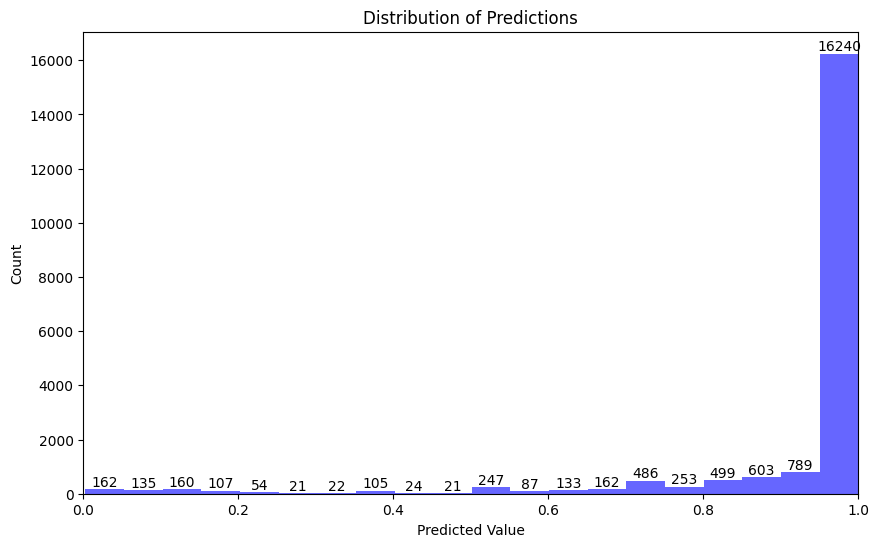

In [23]:
def plot_prediction_distribution(df, column):
    if column not in df.columns:
        raise ValueError(f"Column '{column}' not found in the dataframe.")

    data = df[column]  # Extract the data from the dataframe

    plt.figure(figsize=(10, 6))
    n, bins, patches = plt.hist(data, bins=20, alpha=0.6, color='b')

    # Add counts above the bins
    for count, rect in zip(n, patches):
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2, height, f'{int(count)}', ha='center', va='bottom')

    plt.title('Distribution of Predictions')
    plt.xlabel('Predicted Value')
    plt.ylabel('Count')
    plt.xlim(0, 1)  # Assuming the predictions are probabilities [0, 1]
    plt.show()

# Example usage:
plot_prediction_distribution(logistic_prediction, 'event_prediction')


In [24]:
linear_tree_model.run_pipeline(data=case_data_2023)

Starting Training at 2023-11-30 12:17:52.208913
Testing accuracy: 0.6436108350426085
Ending Training at 2023-11-30 12:17:56.891065
Training took 0:00:04.682152


0.6436108350426085

In [25]:
linear_prediction = linear_tree_model.predict(data=prediction_data_2023)

columns in data before drop: Index(['case_enquiry_id', 'open_dt', 'sla_target_dt', 'closed_dt', 'on_time',
       'case_status', 'closure_reason', 'case_title', 'subject', 'reason',
       'type', 'queue', 'department', 'submitted_photo', 'closed_photo',
       'location', 'fire_district', 'pwd_district', 'city_council_district',
       'police_district', 'neighborhood', 'neighborhood_services_district',
       'ward', 'precinct', 'location_street_name', 'location_zipcode',
       'latitude', 'longitude', 'geom_4326', 'source', 'survival_time',
       'event', 'ward_number', 'survival_time_hours'],
      dtype='object')
columns to drop: Index(['case_status', 'case_title', 'city_council_district', 'closed_dt',
       'closed_photo', 'closure_reason', 'department', 'fire_district',
       'geom_4326', 'latitude', 'location', 'location_street_name',
       'location_zipcode', 'longitude', 'neighborhood',
       'neighborhood_services_district', 'on_time', 'open_dt',
       'police_distric

/home/briarmoss/.local/lib/python3.10/site-packages/boston311/Boston311Model.py:267: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, fake_df], ignore_index=True)


In [26]:
linear_prediction.head(20)

,survival_prediction,case_enquiry_id,open_dt,sla_target_dt,closed_dt,on_time,case_status,closure_reason,case_title,subject,...,location_street_name,location_zipcode,latitude,longitude,geom_4326,source,survival_time,event,ward_number,survival_time_hours
268063,0-2d,101005148011,2023-10-31 01:35:56,2023-11-01 04:30:00,2023-10-31 04:32:13,ONTIME,Closed,Case Closed. Closed date : Tue Oct 31 08:32:13...,Missed Recycling: District 07,Public Works Department,...,10 Middleton St,2124.0,42.282800,-71.086571,0101000020E61000006F76BF5F8AC551C0623AB3C63224...,Constituent Call,0 days 02:56:17,1,14,2.938056
268064,1w1d-1w3d,101005148014,2023-10-31 02:11:47,2023-11-07 03:30:00,2023-11-06 10:19:20,ONTIME,Closed,Case Closed. Closed date : Mon Nov 06 15:19:20...,Electrical,Inspectional Services,...,13 Haviland St,2115.0,42.346440,-71.088671,0101000020E61000006F3D35C7ACC551C0E6E3AC21582C...,Constituent Call,6 days 08:07:33,1,4,152.125833
268065,4d-6d,101005148015,2023-10-31 02:13:52,2023-11-15 03:30:00,2023-11-01 06:49:43,ONTIME,Closed,Case Closed. Closed date : 2023-11-01 10:49:43...,Sign Repair,Transportation - Traffic Division,...,INTERSECTION Melnea Cass Blvd & Hampden St,NaN,42.331177,-71.074821,0101000020E610000018F0ECDFC9C451C0E8A75A04642A...,Citizens Connect App,1 days 04:35:51,1,8,28.597500
268066,0-2d,101005148016,2023-10-31 02:17:02,2023-11-01 04:30:00,2023-11-07 08:23:23,OVERDUE,Closed,Case Closed. Closed date : 2023-11-07 13:23:23...,Parking Enforcement,Transportation - Traffic Division,...,344 Saratoga St,2128.0,42.378933,-71.030609,0101000020E6100000996FDF80F5C151C0890A73E48030...,Citizens Connect App,7 days 06:06:21,1,1,174.105833
268067,0-2d,101005148017,2023-10-31 02:17:38,2023-11-01 04:30:00,2023-11-07 08:23:11,OVERDUE,Closed,Case Closed. Closed date : 2023-11-07 13:23:11...,Parking Enforcement,Transportation - Traffic Division,...,23 Hannon St,2124.0,42.281910,-71.085261,0101000020E61000009C7E34E974C551C07DDED19C1524...,Citizens Connect App,7 days 06:05:33,1,14,174.092500
268068,0-2d,101005148018,2023-10-31 02:17:41,2023-11-02 04:30:00,2023-10-31 10:05:48,ONTIME,Closed,Case Closed. Closed date : Tue Oct 31 14:05:48...,Improper Storage of Trash (Barrels),Public Works Department,...,436 Marlborough St,2215.0,42.349680,-71.089941,0101000020E6100000A9BBF495C1C551C0B0CEC64CC22C...,Citizens Connect App,0 days 07:48:07,1,5,7.801944
268069,0-2d,101005148019,2023-10-31 02:17:44,2023-11-03 04:30:00,2023-10-31 09:52:56,ONTIME,Closed,Case Closed. Closed date : Tue Oct 31 13:52:56...,Poor Conditions of Property,Public Works Department,...,129 Newbury St,2116.0,42.351370,-71.076791,0101000020E610000093C7B722EAC451C0EBA45FADF92C...,Citizens Connect App,0 days 07:35:12,1,5,7.586667
268070,0-2d,101005148020,2023-10-31 02:17:58,2023-11-01 04:30:00,2023-11-07 08:22:58,OVERDUE,Closed,Case Closed. Closed date : 2023-11-07 13:22:58...,Parking Enforcement,Transportation - Traffic Division,...,131 Clarendon St,2116.0,42.348410,-71.073852,0101000020E6100000E7A411FEB9C451C02B32B7AF982C...,Citizens Connect App,7 days 06:05:00,1,4,174.083333
268071,0-2d,101005148023,2023-10-31 02:37:41,2023-11-01 04:30:00,2023-10-31 07:52:08,ONTIME,Closed,Case Closed. Closed date : Tue Oct 31 11:52:08...,"Missed ""Other"" Trash: District 03",Public Works Department,...,39 Esmond St,2121.0,42.298350,-71.085061,0101000020E6100000A1DA2FA271C551C021ED84513026...,Self Service,0 days 05:14:27,1,14,5.240833
268072,4d-6d,101005148026,2023-10-31 02:52:21,2023-11-15 03:30:00,2023-11-07 03:53:03,ONTIME,Closed,Case Closed. Closed date : 2023-11-07 08:53:03...,Sign Repair,Transportation - Traffic Division,...,INTERSECTION Goodale Rd & Blue Hill Ave,NaN,42.282543,-71.092133,0101000020E610000055C33281E5C551C05748FE5D2A24...,Citizens Connect App,7 days 01:00:42,1,14,169.011667


In [27]:
linear_prediction.shape[0]

20310

In [28]:
logistic_prediction.shape[0]

20310

In [29]:
logistic_tree_prediction.shape[0]

20310

##Join the tables

In [30]:
merged_df = logistic_tree_prediction.merge(logistic_prediction[['case_enquiry_id','event_prediction']], on='case_enquiry_id', how="outer").merge(linear_prediction[['case_enquiry_id','survival_prediction']], on='case_enquiry_id', how="outer")

In [31]:
merged_df.shape[0]

20310

In [32]:
merged_df.head()

,event_prediction_x,case_enquiry_id,open_dt,sla_target_dt,closed_dt,on_time,case_status,closure_reason,case_title,subject,...,latitude,longitude,geom_4326,source,survival_time,event,ward_number,survival_time_hours,event_prediction_y,survival_prediction
0,1,101005148011,2023-10-31 01:35:56,2023-11-01 04:30:00,2023-10-31 04:32:13,ONTIME,Closed,Case Closed. Closed date : Tue Oct 31 08:32:13...,Missed Recycling: District 07,Public Works Department,...,42.282800,-71.086571,0101000020E61000006F76BF5F8AC551C0623AB3C63224...,Constituent Call,0 days 02:56:17,1,14,2.938056,1.000000,0-2d
1,1,101005148014,2023-10-31 02:11:47,2023-11-07 03:30:00,2023-11-06 10:19:20,ONTIME,Closed,Case Closed. Closed date : Mon Nov 06 15:19:20...,Electrical,Inspectional Services,...,42.346440,-71.088671,0101000020E61000006F3D35C7ACC551C0E6E3AC21582C...,Constituent Call,6 days 08:07:33,1,4,152.125833,0.550097,1w1d-1w3d
2,1,101005148015,2023-10-31 02:13:52,2023-11-15 03:30:00,2023-11-01 06:49:43,ONTIME,Closed,Case Closed. Closed date : 2023-11-01 10:49:43...,Sign Repair,Transportation - Traffic Division,...,42.331177,-71.074821,0101000020E610000018F0ECDFC9C451C0E8A75A04642A...,Citizens Connect App,1 days 04:35:51,1,8,28.597500,0.920267,4d-6d
3,1,101005148016,2023-10-31 02:17:02,2023-11-01 04:30:00,2023-11-07 08:23:23,OVERDUE,Closed,Case Closed. Closed date : 2023-11-07 13:23:23...,Parking Enforcement,Transportation - Traffic Division,...,42.378933,-71.030609,0101000020E6100000996FDF80F5C151C0890A73E48030...,Citizens Connect App,7 days 06:06:21,1,1,174.105833,0.999838,0-2d
4,1,101005148017,2023-10-31 02:17:38,2023-11-01 04:30:00,2023-11-07 08:23:11,OVERDUE,Closed,Case Closed. Closed date : 2023-11-07 13:23:11...,Parking Enforcement,Transportation - Traffic Division,...,42.281910,-71.085261,0101000020E61000009C7E34E974C551C07DDED19C1524...,Citizens Connect App,7 days 06:05:33,1,14,174.092500,0.999838,0-2d


##Save the prediction data

In [33]:
merged_df.to_csv('predictions.csv', index=False)

In [34]:
import gc
gc.collect()

27

# Enter the Neural Network #

In [35]:
KerasNN_model = Boston311KerasNN()

In [36]:
KerasNN_model.train_date_range={'start':'2023-01-01','end':thirty_days_ago_datestring}

KerasNN_model.predict_date_range={'start':thirty_days_ago_datestring,'end':today_datestring}

KerasNN_model.feature_columns=['queue', 'type']

KerasNN_model.scenario={'dropColumnValues': {'source':['City Worker App', 'Employee Generated']}, 'survivalTimeMin':0, 'survivalTimeFill':tomorrow_datestring}

KerasNN_model.epochs = 2
KerasNN_model.batch_size = 32

In [37]:

hour_interval = 48
max_days = 120

#KerasNN_model.bin_edges = KerasNN_model.generate_time_bins_statistics(df, num_intervals=60)
KerasNN_model.bin_edges = KerasNN_model.generate_time_bins_fixed_interval(hour_interval, max_days)

start_nodes = 256
end_nodes = 128
#l2_0 = 0.00001
#learning_rate = 7.5842e-05
l2_0 = 0.001
learning_rate = 0.0001

hp = HyperParameters()
hp.Fixed('start_nodes', start_nodes)
hp.Fixed('end_nodes', end_nodes)
hp.Fixed('l2_0', l2_0)
hp.Fixed('learning_rate', learning_rate)
bin_number = len(KerasNN_model.bin_edges) - 1
hp.Fixed('final_layer', bin_number)
hp.Fixed('final_activation', 'softmax')
KerasNN_model.best_hyperparameters = hp

In [38]:
KerasNN_model.run_pipeline(data=case_data_2023)

bin_labels is None
Starting Training at 2023-11-30 12:18:00.326868
input_dim: 335
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 256)               86016     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 61)                7869      
                                                                 
Total params: 126781 (495.24 KB)
Trainable params: 126781 (495.24 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
<class 'pandas.core.frame.DataFrame'> (189162, 61)
<class 'pandas.core.frame.DataFrame'> (47291, 61)
run fit

Epoch 1/2


2023-11-30 12:18:01.673321: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 506954160 exceeds 10% of free system memory.


5910/5912 [============================>.] - ETA: 0s - loss: 1.7200 - accuracy: 0.5960 - top_k_categorical_accuracy: 0.7072

2023-11-30 12:18:11.740147: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 253479760 exceeds 10% of free system memory.


5912/5912 [==============================] - 11s 2ms/step - loss: 1.7200 - accuracy: 0.5960 - top_k_categorical_accuracy: 0.7072 - val_loss: 1.7062 - val_accuracy: 0.5748 - val_top_k_categorical_accuracy: 0.6681
Epoch 2/2
 248/1478 [====>.........................] - ETA: 0s - loss: 1.2806 - accuracy: 0.6405 - top_k_categorical_accuracy: 0.7773

2023-11-30 12:18:24.358893: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 126739880 exceeds 10% of free system memory.


1478/1478 [==============================] - 1s 640us/step - loss: 1.4899 - accuracy: 0.6056 - top_k_categorical_accuracy: 0.7189
Testing accuracy: 0.6055697798728943 
Top-2 accuracy: 0.7188894152641296 
Test loss: 1.489896535873413
Ending Training at 2023-11-30 12:18:25.390409
Training took 0:00:25.063541


0.6055697798728943

In [39]:
predictions, data = KerasNN_model.predict(data=prediction_data_2023)

columns in data before drop: Index(['case_enquiry_id', 'open_dt', 'sla_target_dt', 'closed_dt', 'on_time',
       'case_status', 'closure_reason', 'case_title', 'subject', 'reason',
       'type', 'queue', 'department', 'submitted_photo', 'closed_photo',
       'location', 'fire_district', 'pwd_district', 'city_council_district',
       'police_district', 'neighborhood', 'neighborhood_services_district',
       'ward', 'precinct', 'location_street_name', 'location_zipcode',
       'latitude', 'longitude', 'geom_4326', 'source', 'survival_time',
       'event', 'ward_number', 'survival_time_hours'],
      dtype='object')
columns to drop: Index(['case_status', 'case_title', 'city_council_district', 'closed_dt',
       'closed_photo', 'closure_reason', 'department', 'fire_district',
       'geom_4326', 'latitude', 'location', 'location_street_name',
       'location_zipcode', 'longitude', 'neighborhood',
       'neighborhood_services_district', 'on_time', 'open_dt',
       'police_distric

/home/briarmoss/.local/lib/python3.10/site-packages/boston311/Boston311Model.py:267: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, fake_df], ignore_index=True)


635/635 [==============================] - 0s 484us/step


In [40]:
def get_top_predictions(bin_labels, predictions):
    # Check if the number of columns in predictions matches the length of bin_labels
    if len(bin_labels) != predictions.shape[1]:
        raise ValueError("The length of bin_labels must be equal to the number of columns in predictions")

    # Get the indices of the top 3 predictions for each row
    top_3_indices = np.argsort(-predictions, axis=1)[:, :3]

    # Map the indices to labels
    top_3_labels = np.array(bin_labels)[top_3_indices]

    return top_3_labels

def add_prediction_columns(cases_df, top_predictions):
    # Check if the number of rows in the DataFrame matches the number of predictions
    if cases_df.shape[0] != top_predictions.shape[0]:
        raise ValueError("The number of rows in cases_df must be equal to the number of predictions")

    # Create new columns for the predictions
    #cases_df['1st_prediction'] = top_predictions[:, 0]
    #cases_df['2nd_prediction'] = top_predictions[:, 1]
    #cases_df['3rd_prediction'] = top_predictions[:, 2]
    #use insert instead to put them on the left side
    cases_df.insert(0, '1st_prediction', top_predictions[:, 0])
    cases_df.insert(1, '2nd_prediction', top_predictions[:, 1])
    cases_df.insert(2, '3rd_prediction', top_predictions[:, 2])
    
    return cases_df

prediction_labels = get_top_predictions(KerasNN_model.bin_labels, predictions)
df_predictions = add_prediction_columns(data, prediction_labels)

In [41]:
df_predictions.shape[0]

20310

In [42]:
df_predictions.head(100)

,1st_prediction,2nd_prediction,3rd_prediction,case_enquiry_id,open_dt,sla_target_dt,closed_dt,on_time,case_status,closure_reason,...,location_street_name,location_zipcode,latitude,longitude,geom_4326,source,survival_time,event,ward_number,survival_time_hours
268063,0-2d,2d-4d,4d-6d,101005148011,2023-10-31 01:35:56,2023-11-01 04:30:00,2023-10-31 04:32:13,ONTIME,Closed,Case Closed. Closed date : Tue Oct 31 08:32:13...,...,10 Middleton St,2124.0,42.282800,-71.086571,0101000020E61000006F76BF5F8AC551C0623AB3C63224...,Constituent Call,0 days 02:56:17,1,14,2.938056
268064,0-2d,over 114y24w2d16h,2d-4d,101005148014,2023-10-31 02:11:47,2023-11-07 03:30:00,2023-11-06 10:19:20,ONTIME,Closed,Case Closed. Closed date : Mon Nov 06 15:19:20...,...,13 Haviland St,2115.0,42.346440,-71.088671,0101000020E61000006F3D35C7ACC551C0E6E3AC21582C...,Constituent Call,6 days 08:07:33,1,4,152.125833
268065,2d-4d,0-2d,4d-6d,101005148015,2023-10-31 02:13:52,2023-11-15 03:30:00,2023-11-01 06:49:43,ONTIME,Closed,Case Closed. Closed date : 2023-11-01 10:49:43...,...,INTERSECTION Melnea Cass Blvd & Hampden St,NaN,42.331177,-71.074821,0101000020E610000018F0ECDFC9C451C0E8A75A04642A...,Citizens Connect App,1 days 04:35:51,1,8,28.597500
268066,0-2d,2d-4d,4d-6d,101005148016,2023-10-31 02:17:02,2023-11-01 04:30:00,2023-11-07 08:23:23,OVERDUE,Closed,Case Closed. Closed date : 2023-11-07 13:23:23...,...,344 Saratoga St,2128.0,42.378933,-71.030609,0101000020E6100000996FDF80F5C151C0890A73E48030...,Citizens Connect App,7 days 06:06:21,1,1,174.105833
268067,0-2d,2d-4d,4d-6d,101005148017,2023-10-31 02:17:38,2023-11-01 04:30:00,2023-11-07 08:23:11,OVERDUE,Closed,Case Closed. Closed date : 2023-11-07 13:23:11...,...,23 Hannon St,2124.0,42.281910,-71.085261,0101000020E61000009C7E34E974C551C07DDED19C1524...,Citizens Connect App,7 days 06:05:33,1,14,174.092500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268167,0-2d,2d-4d,4d-6d,101005148172,2023-10-31 04:27:10,2023-11-02 04:30:00,2023-10-31 11:11:43,ONTIME,Closed,Case Closed. Closed date : Tue Oct 31 15:11:43...,...,INTERSECTION Paul Sullivan Way & Harrison Ave,NaN,42.342934,-71.065053,0101000020E61000003AE47BD329C451C0149F9C45E52B...,Citizens Connect App,0 days 06:44:33,1,3,6.742500
268168,0-2d,2d-4d,4d-6d,101005148174,2023-10-31 04:27:41,NaN,2023-11-08 11:15:29,ONTIME,Closed,Case Closed. Closed date : 2023-11-08 16:15:29...,...,28 Charles St,2122.0,42.300200,-71.062681,0101000020E6100000AA3E6FF502C451C045272FF06C26...,Constituent Call,8 days 06:47:48,1,15,198.796667
268170,0-2d,2d-4d,4d-6d,101005148176,2023-10-31 04:28:30,2023-11-01 04:30:00,2023-10-31 06:58:24,ONTIME,Closed,Case Closed. Closed date : Tue Oct 31 10:58:24...,...,85-87 Kenwood St,2124.0,42.292570,-71.067691,0101000020E61000000FF6030B55C451C09A7F2BEB7225...,Constituent Call,0 days 02:29:54,1,17,2.498333
268171,0-2d,2d-4d,4d-6d,101005148177,2023-10-31 04:28:41,2023-11-01 04:30:00,2023-11-07 08:12:18,OVERDUE,Closed,Case Closed. Closed date : 2023-11-07 13:12:18...,...,INTERSECTION Congress St & Milk St,NaN,42.356807,-71.056309,0101000020E610000046BEBB909AC351C0E051B5DDAB2D...,Citizens Connect App,7 days 03:43:37,1,3,171.726944


In [43]:
#add the three prediction columns to the merged_df by merging on case_enquiry_id
merged_df = merged_df.merge(df_predictions[['case_enquiry_id','1st_prediction','2nd_prediction','3rd_prediction']], on='case_enquiry_id', how="outer")

In [44]:
# Select and view the first 20 records of the specified columns
columns_to_view = ['1st_prediction', '2nd_prediction', '3rd_prediction', 'survival_prediction', 'event_prediction_x', 'event_prediction_y', 'case_enquiry_id','open_dt','closed_dt','survival_time','case_title','type','queue']
merged_df[columns_to_view].head(20)


,1st_prediction,2nd_prediction,3rd_prediction,survival_prediction,event_prediction_x,event_prediction_y,case_enquiry_id,open_dt,closed_dt,survival_time,case_title,type,queue
0,0-2d,2d-4d,4d-6d,0-2d,1,1.000000,101005148011,2023-10-31 01:35:56,2023-10-31 04:32:13,0 days 02:56:17,Missed Recycling: District 07,Missed Trash/Recycling/Yard Waste/Bulk Item,PWDx_Missed Trash\Recycling\Yard Waste\Bulk Item
1,0-2d,over 114y24w2d16h,2d-4d,1w1d-1w3d,1,0.550097,101005148014,2023-10-31 02:11:47,2023-11-06 10:19:20,6 days 08:07:33,Electrical,Electrical,ISD_Electrical
2,2d-4d,0-2d,4d-6d,4d-6d,1,0.920267,101005148015,2023-10-31 02:13:52,2023-11-01 06:49:43,1 days 04:35:51,Sign Repair,Sign Repair,BTDT_Sign Shop_Sign Installation
3,0-2d,2d-4d,4d-6d,0-2d,1,0.999838,101005148016,2023-10-31 02:17:02,2023-11-07 08:23:23,7 days 06:06:21,Parking Enforcement,Parking Enforcement,BTDT_Parking Enforcement
4,0-2d,2d-4d,4d-6d,0-2d,1,0.999838,101005148017,2023-10-31 02:17:38,2023-11-07 08:23:11,7 days 06:05:33,Parking Enforcement,Parking Enforcement,BTDT_Parking Enforcement
5,0-2d,2d-4d,4d-6d,0-2d,1,1.000000,101005148018,2023-10-31 02:17:41,2023-10-31 10:05:48,0 days 07:48:07,Improper Storage of Trash (Barrels),Improper Storage of Trash (Barrels),PWDx_Code Enforcement
6,0-2d,2d-4d,4d-6d,0-2d,1,1.000000,101005148019,2023-10-31 02:17:44,2023-10-31 09:52:56,0 days 07:35:12,Poor Conditions of Property,Poor Conditions of Property,PWDx_Code Enforcement
7,0-2d,2d-4d,4d-6d,0-2d,1,0.999838,101005148020,2023-10-31 02:17:58,2023-11-07 08:22:58,7 days 06:05:00,Parking Enforcement,Parking Enforcement,BTDT_Parking Enforcement
8,0-2d,2d-4d,4d-6d,0-2d,1,1.000000,101005148023,2023-10-31 02:37:41,2023-10-31 07:52:08,0 days 05:14:27,"Missed ""Other"" Trash: District 03",Missed Trash/Recycling/Yard Waste/Bulk Item,PWDx_Missed Trash\Recycling\Yard Waste\Bulk Item
9,2d-4d,0-2d,4d-6d,4d-6d,1,0.920267,101005148026,2023-10-31 02:52:21,2023-11-07 03:53:03,7 days 01:00:42,Sign Repair,Sign Repair,BTDT_Sign Shop_Sign Installation


In [45]:
#now show the first 20 that have event=0
merged_df[merged_df['event'] == 0][columns_to_view].head(20)

,1st_prediction,2nd_prediction,3rd_prediction,survival_prediction,event_prediction_x,event_prediction_y,case_enquiry_id,open_dt,closed_dt,survival_time,case_title,type,queue
14,over 114y24w2d16h,0-2d,2d-4d,4w6d-5w1d,0,0.048908,101005148035,2023-10-31 03:04:54,NaT,NaT,Parking Enforcement,Parking Enforcement,BPD_Administrative
17,2d-4d,6d-1w1d,4d-6d,4w2d-4w4d,0,0.979847,101005148042,2023-10-31 03:11:17,NaT,NaT,Schedule a Bulk Item Pickup,Schedule a Bulk Item Pickup,PWDx_Schedule a Bulk Item Pickup
48,0-2d,over 114y24w2d16h,2d-4d,0-2d,1,0.894464,101005148091,2023-10-31 03:48:09,NaT,NaT,Animal Generic Request,Animal Generic Request,INFO01_GenericeFormforOtherServiceRequestTypes
53,0-2d,over 114y24w2d16h,2d-4d,2d-4d,1,0.865564,101005148101,2023-10-31 03:55:02,NaT,NaT,Work w/out Permit,Work w/out Permit,ISD_Building (INTERNAL)
58,0-2d,over 114y24w2d16h,2d-4d,4w2d-4w4d,0,0.822459,101005148112,2023-10-31 04:01:12,NaT,NaT,Work Hours-Loud Noise Complaints,Work Hours-Loud Noise Complaints,PWDx_Work Hours-Loud Noise Complaints
93,over 114y24w2d16h,0-2d,2d-4d,4w2d-4w4d,0,0.342972,101005148170,2023-10-31 04:25:00,NaT,NaT,Request for Pothole Repair,Request for Pothole Repair,PWDx_Roadway Repair_Reconstruction
102,2d-4d,6d-1w1d,4d-6d,4w2d-4w4d,0,0.979847,101005148187,2023-10-31 04:32:21,NaT,NaT,Schedule a Bulk Item Pickup,Schedule a Bulk Item Pickup,PWDx_Schedule a Bulk Item Pickup
114,0-2d,over 114y24w2d16h,2d-4d,2d-4d,1,0.885837,101005148208,2023-10-31 04:41:15,NaT,NaT,Contractors Complaint,Contractors Complaint,ISD_Building (INTERNAL)
118,over 114y24w2d16h,0-2d,2d-4d,4w4d-4w6d,0,0.090356,101005148215,2023-10-31 04:45:00,NaT,NaT,Request for Pothole Repair,Request for Pothole Repair,BWSC_All Cases
120,over 114y24w2d16h,0-2d,2d-4d,4w4d-4w6d,0,0.141267,101005148219,2023-10-31 04:47:00,NaT,NaT,Traffic Signal Inspection,Traffic Signal Inspection,INFO_Mass DCR


In [46]:


def plot_prediction_distribution(df, prediction_cols):
    # Set the aesthetic style of the plots
    sns.set_style("whitegrid")

    # Create figure and axes
    fig, axes = plt.subplots(nrows=len(prediction_cols), figsize=(10, 5 * len(prediction_cols)))

    if not isinstance(axes, np.ndarray):
        axes = [axes]

    # Plot the distribution of each prediction
    for ax, col in zip(axes, prediction_cols):
        sns.countplot(data=df, x=col, hue=col, palette="viridis", order=df[col].value_counts().index, ax=ax)
        ax.set_title(f'Distribution of {col}')
        ax.set_xlabel('Labels')
        ax.set_ylabel('Frequency')
        for p in ax.patches:
            ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
        plt.xticks(rotation=45)

    # Adjust layout
    plt.tight_layout()
    plt.show()

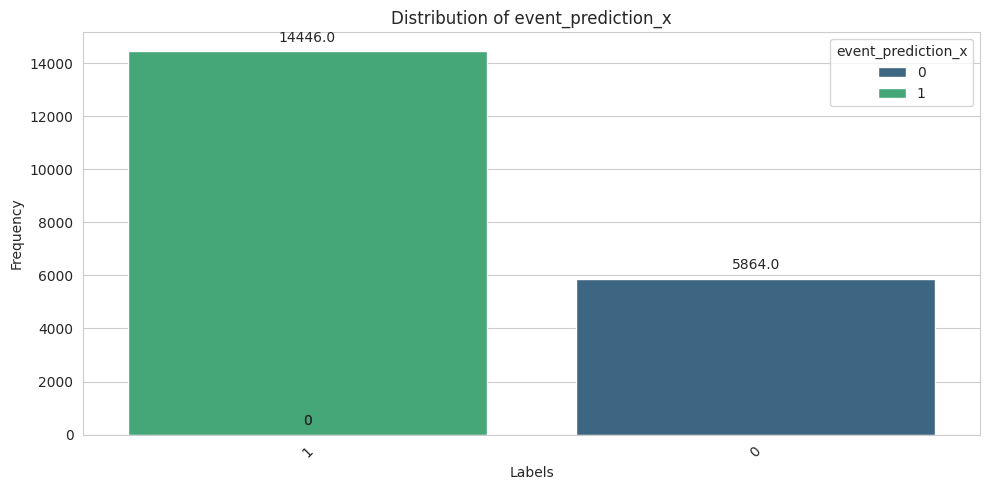

In [47]:
# Assuming `merged_df` is your DataFrame with columns '1st_prediction', '2nd_prediction', '3rd_prediction'
# Example usage:
plot_prediction_distribution(merged_df, ['event_prediction_x'])

In [48]:
merged_df['survival_prediction'].value_counts()

survival_prediction
0-2d                  12180
4w2d-4w4d              1809
3w1d-3w3d              1700
3w5d-4w                1071
4w4d-4w6d               899
2d-4d                   704
10w2d-10w4d             662
4d-6d                   520
4w6d-5w1d               206
2w-2w2d                 192
1w1d-1w3d               127
1w3d-1w5d               101
2w2d-2w4d                59
2w4d-2w6d                31
4w-4w2d                  16
6w4d-6w6d                 7
7w3d-7w5d                 6
7w1d-7w3d                 5
5w5d-6w                   3
5w3d-5w5d                 3
6w2d-6w4d                 2
17w1d-114y24w2d16h        2
9w1d-9w3d                 2
13w3d-13w5d               1
9w5d-10w                  1
13w5d-14w                 1
Name: count, dtype: int64

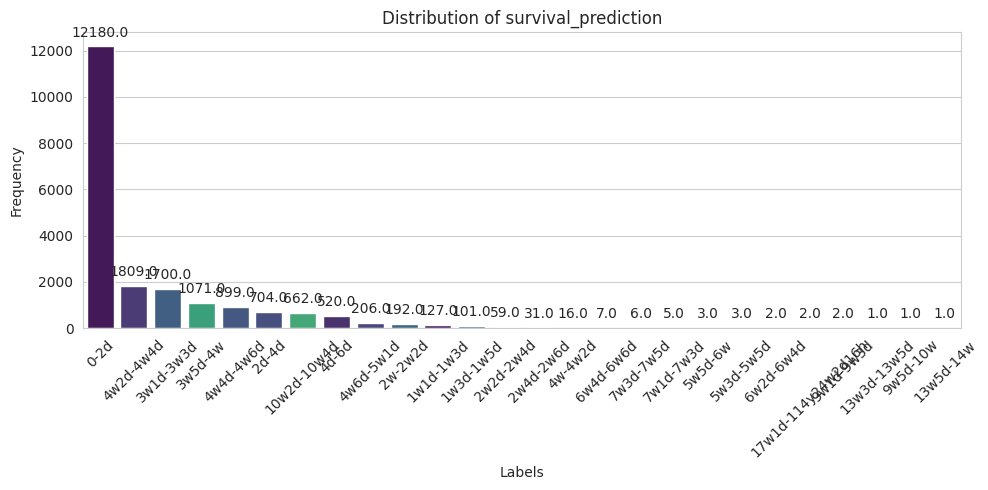

In [49]:

plot_prediction_distribution(merged_df, ['survival_prediction'])

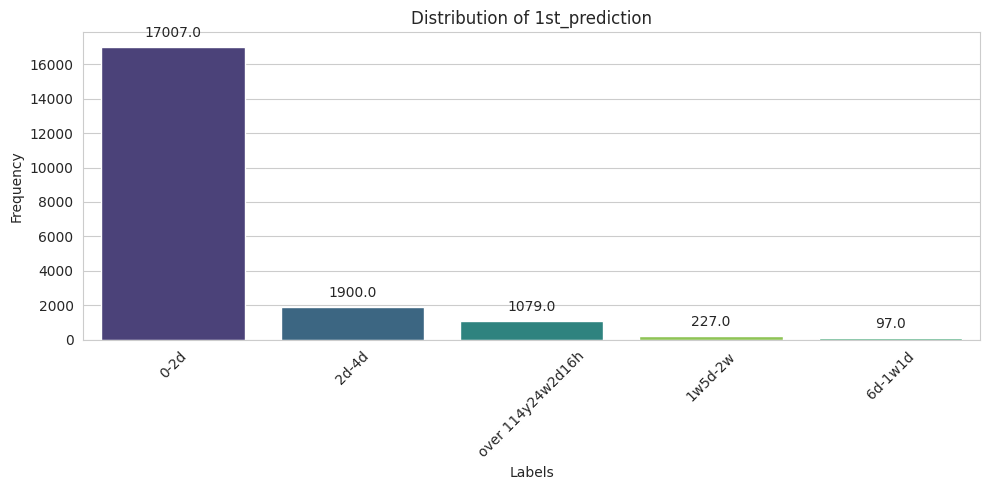

In [50]:

plot_prediction_distribution(merged_df, ['1st_prediction'])

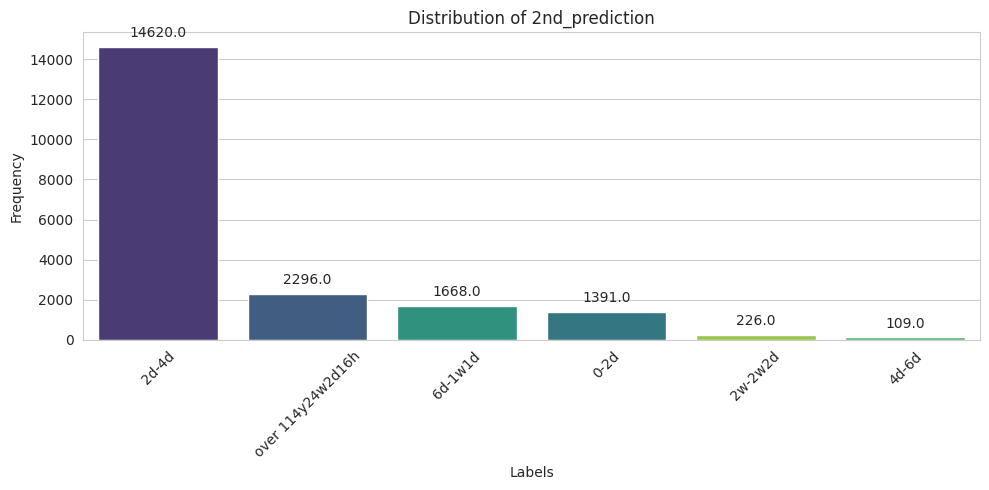

In [51]:

plot_prediction_distribution(merged_df, ['2nd_prediction'])

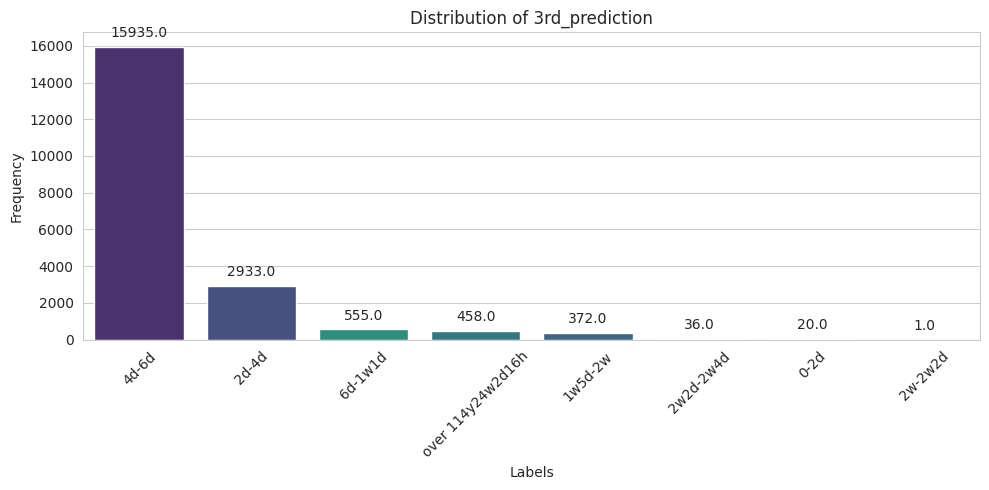

In [52]:

plot_prediction_distribution(merged_df, ['3rd_prediction'])